In [1]:
import colormaps as cmaps
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pycountry
import re
import seaborn as sns
from publib import set_style, fix_style
import publib.tools
from IPython.core.display import HTML
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython

#import stata_setup
#stata_setup.config('c:\Program Files\Stata17', 'mp', splash=False)
#from pystata import stata

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 20)
pd.set_option('display.max_rows', 120)
publib.tools.regenerate_fonts
sns.set_style("whitegrid")
set_style(['origin'])
#plt.rcParams.update({'font.size': 10})

df = pd.read_parquet("df_soep2.gzip")
#df.to_stata("to_stata.dta")

### INITIALIZE ###


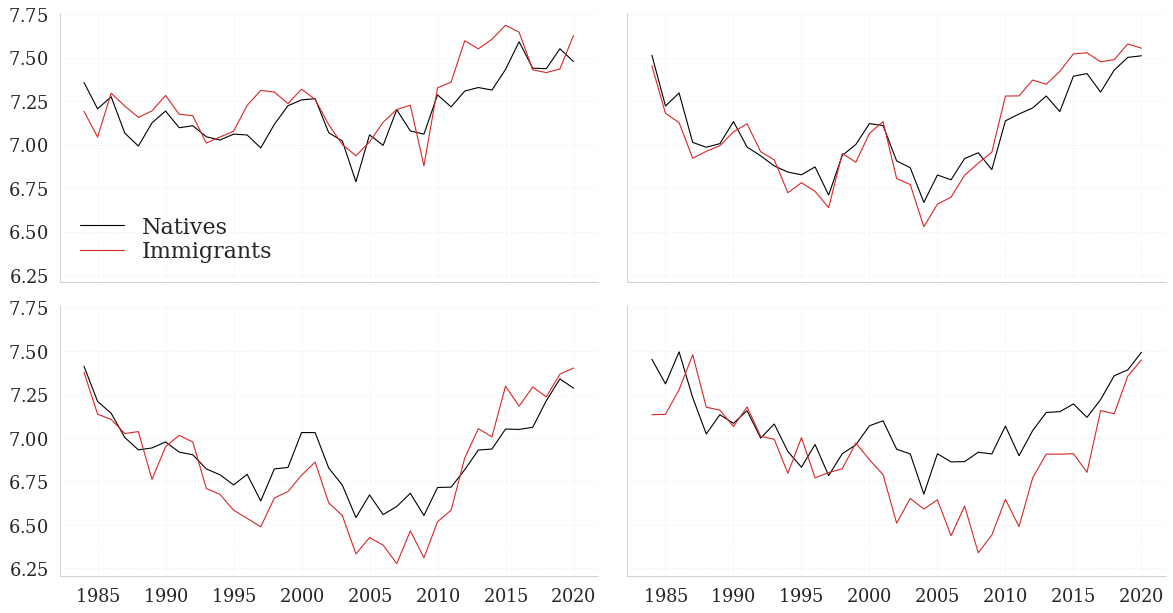

In [2]:
import matplotlib.lines as mlines

# Sort cohorts, remove NaN, structure the subplots

cohorts = sorted(
    [
        cohort
        for cohort in df["cohort"].unique()
        if pd.notna(cohort) and cohort != "nan"
    ],
    key=lambda x: int(x.split("-")[0]) if "-" in x else int(x.split("+")[0]),
)

n_rows = (len(cohorts) + 2) // 3
n_cols = min(2, len(cohorts))

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(15, 4 * n_rows), sharex=True, sharey=True
)

# Function to correctly export subplots as files

def save_subplot(i, df_cohort):
    fig, new_ax = plt.subplots()
    
    df_migback1 = df_cohort[df_cohort["migback"] == 1]
    df_migback23 = df_cohort[df_cohort["migback"].isin([2, 3])]
    
    mean_satisfaction_1 = df_migback1.groupby("syear").apply(lambda x: np.average(x['satisfaction'], weights=x['hochrechnungsfaktor']))
    mean_satisfaction_23 = df_migback23.groupby("syear").apply(lambda x: np.average(x['satisfaction'], weights=x['hochrechnungsfaktor']))
    
    new_ax.plot(mean_satisfaction_1.index, mean_satisfaction_1.values, color="k", linestyle="-")
    new_ax.plot(mean_satisfaction_23.index, mean_satisfaction_23.values, color="tab:red", linestyle="-")
    
    if i == 0:
        new_ax.legend(['Natives', 'Immigrants'])
    
    # Remove top and right borders here
    new_ax.spines['top'].set_visible(False)
    new_ax.spines['right'].set_visible(False)
    new_ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    fig.savefig(f"cohort_plot_{i}.pdf")
    plt.close(fig)

# Create subplots
for i, cohort in enumerate(cohorts):
    ax = axes[i // n_cols, i % n_cols]
    df_cohort = df[df["cohort"] == cohort]
    
    df_migback1 = df_cohort[df_cohort["migback"] == 1]
    df_migback23 = df_cohort[df_cohort["migback"].isin([2, 3])]
    
    mean_satisfaction_1 = df_migback1.groupby("syear").apply(lambda x: np.average(x['satisfaction'], weights=x['hochrechnungsfaktor']))
    mean_satisfaction_23 = df_migback23.groupby("syear").apply(lambda x: np.average(x['satisfaction'], weights=x['hochrechnungsfaktor']))
    
    ax.plot(mean_satisfaction_1.index, mean_satisfaction_1.values, color="k", linestyle="-")
    ax.plot(mean_satisfaction_23.index, mean_satisfaction_23.values, color="tab:red", linestyle="-")
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    if i == 0:  # Adding legend only to the first plot
        ax.legend(['Natives', 'Immigrants'])
    
    # Save individual subplots
    if ax.has_data():  
        save_subplot(i, df_cohort)

# Hide empty subplots
for i in range(len(cohorts), n_rows * n_cols):
    axes[i // n_cols, i % n_cols].axis('off')

fig.tight_layout()
plt.show()


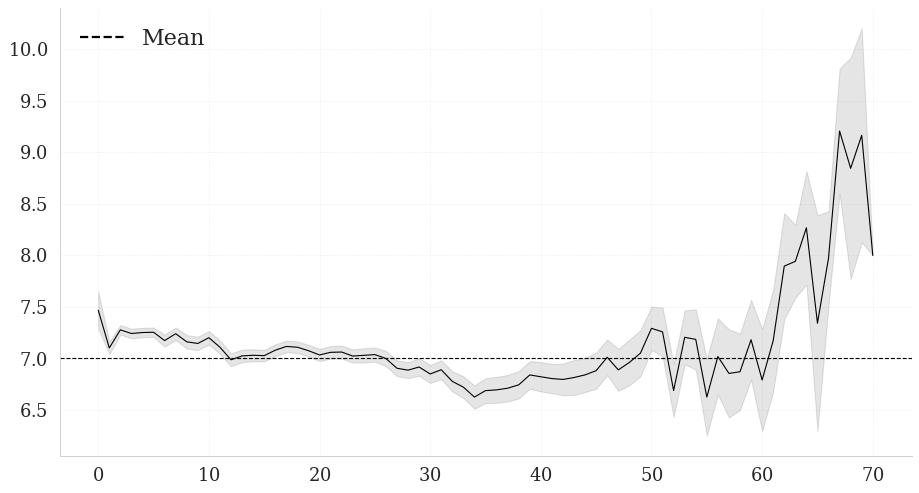

In [3]:
def weighted_mean_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return average, np.sqrt(variance)

# Select direct migrants, group by years in Germany and create confidence interval
df_migback1 = df[(df["migback"] == 2)]

grouped = df_migback1.groupby("y_in_germany")

weighted_means = []
weighted_stds = []
years_in_germany = []

for name, group in grouped:
    m, s = weighted_mean_and_std(group['satisfaction'], group['hochrechnungsfaktor'])
    weighted_means.append(m)
    weighted_stds.append(s)
    years_in_germany.append(name)

ci = 1.96 * (np.array(weighted_stds)/np.sqrt(grouped.size()))

# Creating a DataFrame for easy plotting with Seaborn
plot_data = pd.DataFrame({
    'years_in_germany': years_in_germany,
    'weighted_means': weighted_means,
    'ci_low': weighted_means - ci,
    'ci_high': weighted_means + ci
})

# Plotting
plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='years_in_germany', y='weighted_means', data=plot_data, color='k', linewidth=1)
ax.fill_between(plot_data['years_in_germany'], plot_data['ci_low'], plot_data['ci_high'], alpha=0.1, color='k')

global_avg_satisfaction = np.average(df_migback1['satisfaction'], weights=df_migback1['hochrechnungsfaktor'])
plt.axhline(y=global_avg_satisfaction, linestyle='--', color='k')  # Removed label argument

# Enhancing the plot
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(handles=[plt.Line2D([0], [0], color='k', lw=2, linestyle='--')], labels=['Mean'], loc='upper left')  # Added loc argumentax.grid(True)
sns.despine()
plt.savefig('years_germany.pdf')
plt.show()

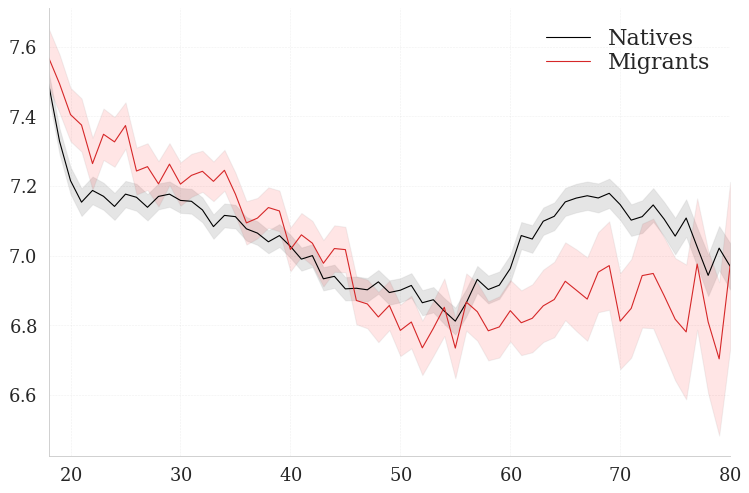

In [4]:
from scipy.stats import sem, t

# Function to calculate weighted mean and confidence interval
def weighted_stats(x, weights):
    mean = np.average(x, weights=weights)
    variance = np.average((x - mean)**2, weights=weights)
    conf_interval = 1.96 * np.sqrt(variance / len(x))  # 95% CI
    return pd.Series([mean, conf_interval], index=['mean', 'conf_interval'])

# Filtering natives and migrants
df_natives = df[df['migback'] == 1]
df_migrants = df[df['migback'] == 2]

# Limiting data to the age range 18 to 80
df_natives = df_natives[df_natives['age'].between(18, 80)]
df_migrants = df_migrants[df_migrants['age'].between(18, 80)]

# Apply function to both groups
grouped_natives = df_natives.groupby('age').apply(lambda x: weighted_stats(x['satisfaction'], x['hochrechnungsfaktor']))
grouped_migrants = df_migrants.groupby('age').apply(lambda x: weighted_stats(x['satisfaction'], x['hochrechnungsfaktor']))

plt.figure(figsize=(12, 8))

# Plotting
sns.lineplot(x=grouped_natives.index, y=grouped_natives['mean'], label='Natives')
plt.fill_between(grouped_natives.index, grouped_natives['mean'] - grouped_natives['conf_interval'], grouped_natives['mean'] + grouped_natives['conf_interval'], alpha=0.1)

sns.lineplot(x=grouped_migrants.index, y=grouped_migrants['mean'], label='Migrants', color="tab:red")
plt.fill_between(grouped_migrants.index, grouped_migrants['mean'] - grouped_migrants['conf_interval'], grouped_migrants['mean'] + grouped_migrants['conf_interval'], alpha=0.1)

sns.despine()

plt.xlabel('')
plt.ylabel('')
#plt.title('Satisfaction by Age')
plt.xlim(18, 80)
plt.savefig('satisf_age.pdf')
plt.show();

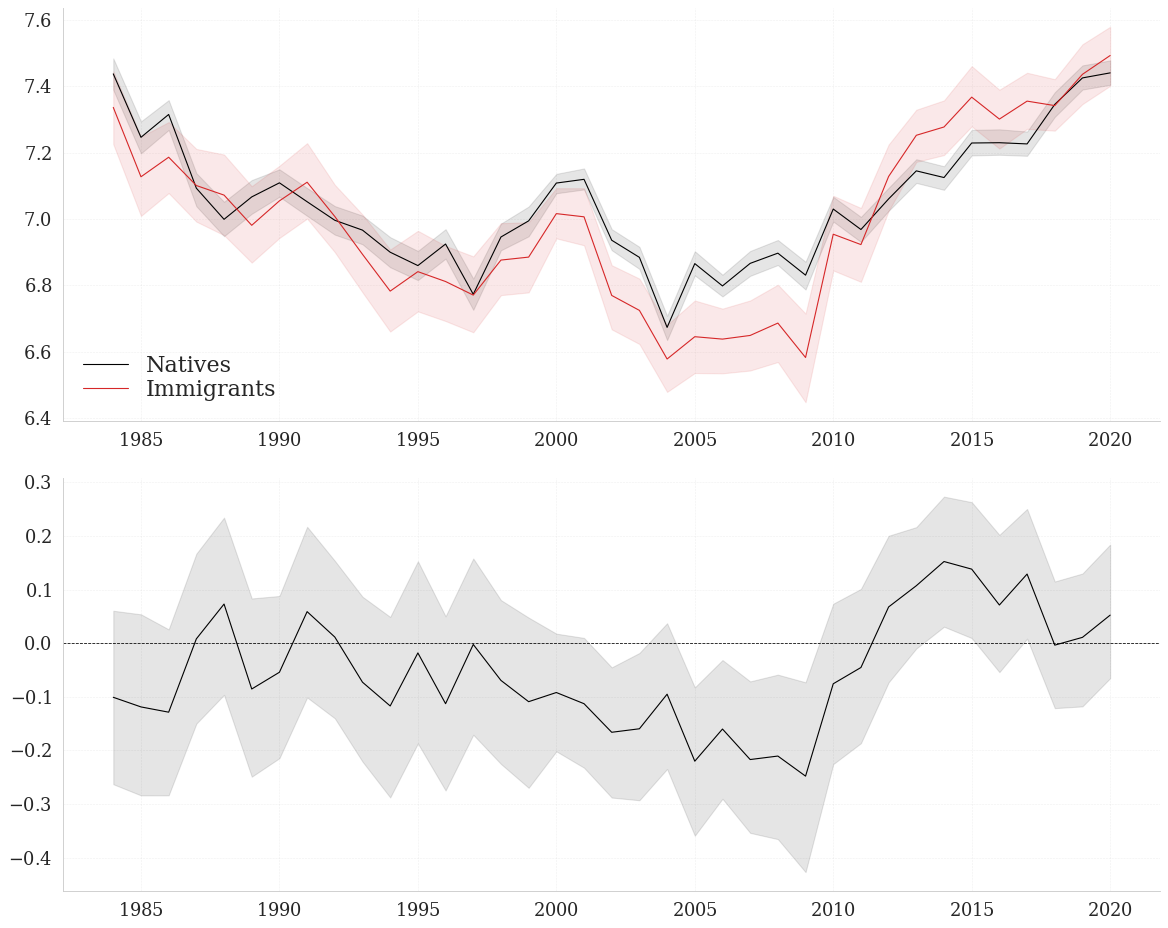

In [5]:
import matplotlib.patches as mpatches

df = pd.read_parquet("df_soep2.gzip")

# Calculate CI
def bootstrap_ci(data, weights, n_iterations=1000, alpha=0.05):
    boot_means = np.zeros(n_iterations)
    indices = np.arange(len(data))
    for i in range(n_iterations):
        boot_indices = np.random.choice(indices, len(indices), replace=True)
        boot_data = data.iloc[boot_indices]
        boot_weights = weights.iloc[boot_indices]
        boot_means[i] = np.average(boot_data, weights=boot_weights)
    lower = np.percentile(boot_means, 100 * (alpha / 2.0))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2.0))
    return lower, upper

# Create subplot 1
def plot_subplot1():
    for migback, color, label in [(1, "k", "Natives"), (2, "tab:red", "Immigrants")]:
        migback_df = df[df["migback"] == migback]
        years = sorted(migback_df['syear'].unique())
        
        means = []
        lower_bounds = []
        upper_bounds = []
        
        for year in years:
            year_data = migback_df[migback_df['syear'] == year]['satisfaction']
            year_weights = migback_df[migback_df['syear'] == year]['hochrechnungsfaktor']
            
            mean = np.average(year_data, weights=year_weights)
            lower, upper = bootstrap_ci(year_data, year_weights)
            
            means.append(mean)
            lower_bounds.append(lower)
            upper_bounds.append(upper)
        
        plt.plot(years, means, color=color, label=label)
        plt.fill_between(years, lower_bounds, upper_bounds, color=color, alpha=0.1)
    
    plt.legend()
    plt.grid(True)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Create subplot 2
def plot_subplot2():
    years = sorted(df['syear'].unique())
    diff_means = []
    diff_lower_bounds = []
    diff_upper_bounds = []
    for year in years:
        year_data1 = df[(df['migback'] == 1) & (df['syear'] == year)]['satisfaction']
        year_weights1 = df[(df['migback'] == 1) & (df['syear'] == year)]['hochrechnungsfaktor']
        year_data2 = df[(df['migback'] == 2) & (df['syear'] == year)]['satisfaction']
        year_weights2 = df[(df['migback'] == 2) & (df['syear'] == year)]['hochrechnungsfaktor']
        
        mean1 = np.average(year_data1, weights=year_weights1)
        mean2 = np.average(year_data2, weights=year_weights2)
        
        lower1, upper1 = bootstrap_ci(year_data1, year_weights1)
        lower2, upper2 = bootstrap_ci(year_data2, year_weights2)
        
        diff_means.append(mean2 - mean1)
        diff_lower_bounds.append(lower2 - upper1)
        diff_upper_bounds.append(upper2 - lower1)
    
    plt.plot(years, diff_means, color='k', label='Difference (Immigrants - Natives)')
    plt.fill_between(years, diff_lower_bounds, diff_upper_bounds, color='k', alpha=0.1)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=0.7)
    
    #plt.legend()
    plt.grid(True)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

# Save subplot1
fig1 = plt.figure(figsize=(15, 6))
plot_subplot1()
plt.tight_layout()
fig1.savefig('subplot1.pdf')
plt.close(fig1)

# Save subplot2
fig2 = plt.figure(figsize=(15, 6))
plot_subplot2()
plt.tight_layout()
fig2.savefig('subplot2.pdf')
plt.close(fig2)

# Display combined subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
plt.sca(ax1)
plot_subplot1()
plt.sca(ax2)
plot_subplot2()
plt.tight_layout()
plt.show()


In [6]:
# Create age groups
bins = [18, 28, 38, 48, 58, 68]
labels = ['18-28', '29-38', '39-48', '49-58', '59-68']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Calculate weighted mean
def weighted_mean(values, weights):
    return np.average(values, weights=weights)

grouped = df.groupby(['syear', 'age_group', 'migback']).apply(
    lambda x: weighted_mean(x['satisfaction'], x['hochrechnungsfaktor']))

# Calculate differences in satisfaction between migrants and natives for each age group and year
differences = grouped.unstack().fillna(0)
differences['diff'] = differences[2] - differences[1]

# Reformat data for plotting
differences.reset_index(inplace=True)
heatmap_data = differences.pivot(index='age_group', columns='syear', values='diff')

# Create heatmap
fig = px.imshow(heatmap_data, labels=dict(x="Year", y="Age Group", color="Difference"),
                x=heatmap_data.columns,
                y=heatmap_data.index,
                color_continuous_scale="RdBu",
                title="Difference in Satisfaction by Age Group and Year")

fig.show(renderer='iframe')


Top 5 countries with the highest average deviation in satisfaction:
    corigin_str  deviation_from_global
55       Mexico             1.328238  
42        Japan             1.099815  
89    Venezuela             1.064049  
48       Kuwait             1.030795  
78  Switzerland             0.951546  

Top 5 countries with the lowest average deviation in satisfaction:
   corigin_str  deviation_from_global
37       India            -1.263977  
32       Ghana            -1.427624  
52       Libya            -1.458203  
8   Bangladesh            -1.923180  
35      Guinea            -2.031158  


/tmp/ipykernel_679/2312867667.py:53: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



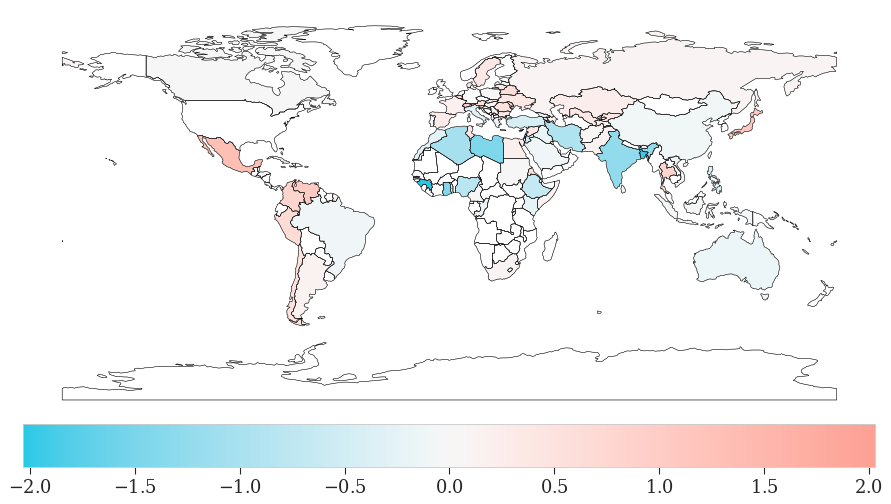

In [7]:
import geopandas as gpd

# Select direct migrants
df = df[df["migback"] == 2]

# Calculate averages
def weighted_average_satisfaction(group, global_avg):
    weights = group['hochrechnungsfaktor']
    satisf = group['satisfaction']
    
    valid_entries = ~np.isnan(weights) & ~np.isnan(satisf)
    weights = weights[valid_entries]
    satisf = satisf[valid_entries]
    
    total_weights = weights.sum()
    if total_weights == 0:
        return None
    
    country_avg_satisf = (weights * satisf).sum() / total_weights
    deviation_from_global = country_avg_satisf - global_avg.get(group.name[1], None)
    return deviation_from_global

# Only use last 15 years, minimum of 20 invidividuals
last_15_years = df['syear'].max() - 15
filtered_df = df[df['syear'] > last_15_years]

valid_countries = df.groupby('corigin_str').pid.nunique()
valid_countries = valid_countries[valid_countries >= 20].index.tolist()
filtered_df = filtered_df[filtered_df['corigin_str'].isin(valid_countries)]

# Exclude Germany
filtered_df = filtered_df[filtered_df['corigin_iso'] != 'DEU']

# Calculate deviation from average
global_avg = filtered_df.groupby('syear').apply(lambda x: (x['hochrechnungsfaktor'] * x['satisfaction']).sum() / x['hochrechnungsfaktor'].sum())

grouped_df = filtered_df.groupby(['corigin_str', 'syear']).apply(weighted_average_satisfaction, global_avg=global_avg).reset_index()
grouped_df.columns = ['corigin_str', 'syear', 'deviation_from_global']

average_deviation = grouped_df.groupby('corigin_str')['deviation_from_global'].mean().reset_index()

sorted_deviation = average_deviation.sort_values(by='deviation_from_global', ascending=False)

# Printing the top 5 countries with the highest average deviation
print("Top 5 countries with the highest average deviation in satisfaction:")
print(sorted_deviation.head(5))

# Printing the bottom 5 countries with the lowest average deviation
print("\nTop 5 countries with the lowest average deviation in satisfaction:")
print(sorted_deviation.tail(5))

# Create plot
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(average_deviation, how="left", left_on="name", right_on="corigin_str")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
vmax = max(abs(world['deviation_from_global'].dropna()))
vmin = -vmax

world.boundary.plot(ax=ax, linewidth=0.4)
img = world.plot(column='deviation_from_global', cmap=cmaps.cet_d_tritanopic_cwr, linewidth=0.4, ax=ax,
                 legend=True, legend_kwds={'orientation': 'horizontal', 'pad': 0.01}, 
                 vmin=vmin, vmax=vmax, missing_kwds={'color': 'white'})

ax.set_axis_off()
#plt.title('Deviation from Mean Immigrant LS (2005-2020)')
plt.savefig('map_deviation_from_global.pdf')
plt.show()

Top 5 countries with the highest average LS difference to peers in origin country:
   corigin_str  weighted_satisf_diff
37     Moldova             2.983827 
42   Palestine             2.063344 
63     Ukraine             1.964451 
60     Tunisia             1.865640 
23        Iraq             1.826903 

Top 5 countries with the lowest average LS difference to peers in origin country:
      corigin_str  weighted_satisf_diff
17  Great Britain            -0.577583 
0       Australia            -0.600984 
8        Colombia            -0.767611 
57     Tajikistan            -0.953314 
33          Libya            -1.463745 


/tmp/ipykernel_679/4056599188.py:45: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



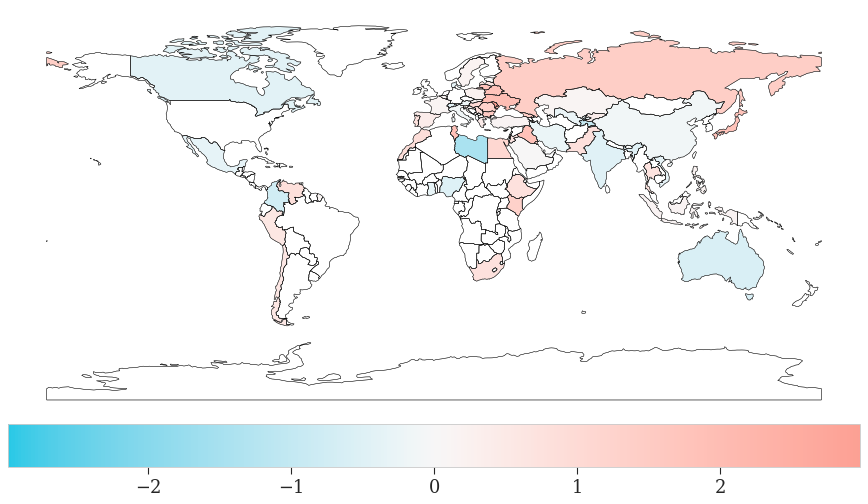

In [8]:
# Calculate weighted mean
def weighted_mean_diff(group):
    weights = group['hochrechnungsfaktor']
    satisf = group['satisfaction']
    peers = group['satisf_peers']

    # Check for zero or NaN in weights
    total_weights = sum(weights)
    if total_weights == 0 or np.isnan(total_weights):
        return None

    weighted_diff = sum(weights * (satisf - peers)) / total_weights
    return weighted_diff

# Filters for observations in the last 15 years & direct migrants
last_5_years = df['syear'].max() - 15
filtered_df = df[df['syear'] > last_5_years]

filtered_df = df[(df['migback'].isin([2]))]

# Filter for countries with 20+ unique pids
valid_countries = df.groupby('corigin_str').pid.nunique()
valid_countries = valid_countries[valid_countries >= 20].index.tolist()
filtered_df = filtered_df[filtered_df['corigin_str'].isin(valid_countries)]

filtered_df = filtered_df.dropna(subset=['satisfaction', 'satisf_peers', 'hochrechnungsfaktor'])

# Calculating differences
grouped_df = filtered_df.groupby(['corigin_str', 'syear']).apply(weighted_mean_diff).reset_index()
grouped_df.columns = ['corigin_str', 'syear', 'weighted_satisf_diff']

average_diff = grouped_df.groupby('corigin_str')['weighted_satisf_diff'].mean().reset_index()

sorted_diff = average_diff.sort_values(by='weighted_satisf_diff', ascending=False)

# Printing the 5 countries with the highest average deviation
print("Top 5 countries with the highest average LS difference to peers in origin country:")
print(sorted_diff.head(5))

# Printing the 5 countries with the lowest average deviation
print("\nTop 5 countries with the lowest average LS difference to peers in origin country:")
print(sorted_diff.tail(5))

# Plotting
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(average_diff, how="left", left_on="name", right_on="corigin_str")

fig, ax = plt.subplots(1, figsize=(15, 10))
vmax = max(abs(world['weighted_satisf_diff'].dropna()))
vmin = -vmax

world.boundary.plot(ax=ax, linewidth=0.4)
world.plot(column='weighted_satisf_diff', cmap=cmaps.cet_d_tritanopic_cwr, linewidth=0.4, ax=ax,
           legend=True, legend_kwds={'orientation': 'horizontal', 'pad': 0.01}, vmin=vmin, vmax=vmax,
           missing_kwds={'color': 'white'})

ax.set_axis_off()
#plt.title('LS Difference to Peers in Origin Country (2005-2020)')
plt.savefig('map_difftopeers.pdf')
plt.show()